# Notebook Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# get current working directory
import os
os.getcwd()

'/home/jovyan/ds_nudge_up/playground'

In [3]:
# change working directory to the root of the project
os.chdir('/home/jovyan/ds_nudge_up/')

In [4]:
import sys
sys.path += ["../"]

import warnings
warnings.filterwarnings("ignore")

In [5]:
import os
import src.mosaiks.utils as utl
rasterio_config = utl.load_yaml_config("rasterioc_config.yaml")
os.environ.update(rasterio_config)

#### `pip install` MOSAIKS

From local folder:

In [6]:
!pip install -e .

Obtaining file:///home/jovyan/ds_nudge_up
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mosaiks (pyproject.toml) ... done
  Created wheel for mosaiks: filename=mosaiks-0.0.1rc0-0.editable-py3-none-any.whl size=2238 sha256=18771cd043f9495a5e989e94fa1134c02134c77cdf904787f23a2665915a5c56
  Stored in directory: /tmp/pip-ephem-wheel-cache-oto7b1jv/wheels/b9/af/5e/752b683d2cb159d37a03ef74be9f004303ccd51e4ee80d1e9c
Successfully built mosaiks
  Attempting uninstall: mosaiks
    Found existing installation: mosaiks 0.0.1rc0
    Uninstalling mosaiks-0.0.1rc0:
      Successfully uninstalled mosaiks-0.0.1rc0


From GitHub package:

🚨🚨 **Make sure you update github token in the secrets file** 🚨🚨 

In [7]:
# secrets = utl.load_yaml_config("../secrets.yaml")
# GITHUB_TOKEN = secrets["GITHUB_TOKEN"]
# mosaiks_package_link = f"git+https://{GITHUB_TOKEN}@github.com/IDinsight/ds_nudge_up@as-package"

In [8]:
# !pip uninstall mosaiks -y
# !pip install {mosaiks_package_link} --upgrade

# Setup Dask Cluster and Client

## Local Cluster

4 workers with 4 threads each seem to work best. A lot of time a thread is waiting on data to load so CPU is underutilized.

In [9]:
import logging
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=4, processes=True, threads_per_worker=4, silence_logs=logging.ERROR)
client = Client(cluster)
client

2023-02-19 17:21:04,287 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/ds_nudge_up/dask-worker-space/worker-nqrtte15', purging
2023-02-19 17:21:04,288 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/ds_nudge_up/dask-worker-space/worker-2hhp4iym', purging
2023-02-19 17:21:04,288 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/ds_nudge_up/dask-worker-space/worker-_2s0hcf5', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/amirali1376@gmail.com/proxy/8787/status,
Dashboard: /user/amirali1376@gmail.com/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 27.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44333,Workers: 4
Dashboard: /user/amirali1376@gmail.com/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 27.00 GiB
Comm: tcp://127.0.0.1:38459,Total threads: 4
Dashboard: /user/amirali1376@gmail.com/proxy/34959/status,Memory: 6.75 GiB
Nanny: tcp://127.0.0.1:42499,


# Load params

In [10]:
from mosaiks.featurize import *

from dask import delayed
from dask.distributed import as_completed
from time import sleep
import pandas as pd
import numpy as np

In [11]:
featurization_config = utl.load_yaml_config("featurisation.yaml")
satellite_config = utl.load_yaml_config("satellite_config.yaml")
satellite_config = satellite_config[featurization_config['satellite_search_params']['satellite_name']]
data_sources = utl.load_yaml_config('data_catalog.yaml')

# Load point coords

In [12]:
points_gdf = utl.load_points_gdf(**data_sources['request_points_centroids'])

In [13]:
focus_states_id_dict = {
    20:"jharkhand",
    22:"chhattisgarh",
    8:"rajasthan",
    23:"madhya pradesh",
    18:"assam",
    16:"tripura",
}
focus_states_filter = points_gdf["pc11_s_id"].isin(focus_states_id_dict.keys())

In [14]:
points_gdf_focus = points_gdf[focus_states_filter]
points_gdf_focus.shape

(179716, 9)

In [15]:
points_gdf_focus["shrid"].drop_duplicates(keep='first').shape

(175855,)

In [16]:
# points_gdf_focus.plot(markersize=0.01)

In [17]:
# temp = points_gdf_focus.sample(300) #gpd.GeoDataFrame(points_gdf_focus.loc[500042]).T

# Fetch image stac refs

`fetch_image_refs` now returns a dask dataframe and is not yet computed. So it finishes quite quickly.

In [33]:
%%time
points_gdf_with_stac = fetch_image_refs(
    points_gdf_focus, 
    featurization_config['dask']['n_partitions'],
    featurization_config['satellite_search_params']
)

CPU times: user 2.21 s, sys: 185 ms, total: 2.39 s
Wall time: 7.74 s


# Define delayed objects

We use the `delayed` decorator to turn our function into a delayed function. This means it will not run immediately when called but instead return a delayed object that can be run later

In [34]:
@delayed
def partition_run(df, satellite_config, featurization_config, model, device):
    
    data_loader = create_data_loader(df, satellite_config, featurization_config['model']['batch_size'])
    X_features = create_features(data_loader, featurization_config['model']['num_features'], len(df), 
                             model, device, satellite_config['min_image_edge'])
    
    df = pd.DataFrame(X_features, index=df.index.copy())
    
    return df

We want to convert our dask dataframe into "delayed" objects. Each partition is now a delayed pandas dataframe and can be passed to our delayed function above

In [35]:
partitions = points_gdf_with_stac.to_delayed()

In [36]:
model = RCF(featurization_config['model']['num_features'], 
            featurization_config['model']['kernel_size'], 
            len(satellite_config['bands']))

# Diagnostics

### Run for the problematic partition

In [37]:
p_44 = partitions[44].compute()

In [38]:
# a = p_44.reset_index()
# a[a["index"]==500042]

In [42]:
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
import stackstac

500042
Intersects bbox? False
Intersects STAC geometry? True


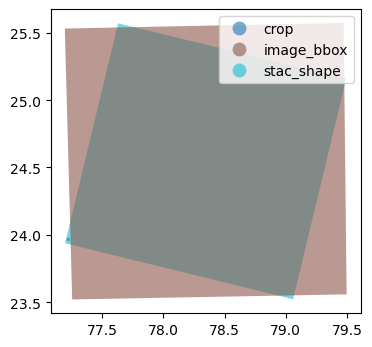

500045
Intersects bbox? False
Intersects STAC geometry? True


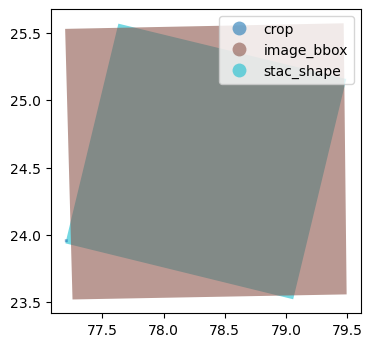

500063
Intersects bbox? False
Intersects STAC geometry? True


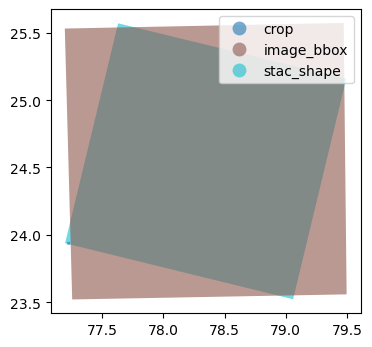

500049
Intersects bbox? False
Intersects STAC geometry? True


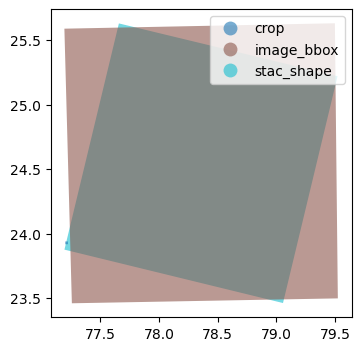

500051
Intersects bbox? False
Intersects STAC geometry? True


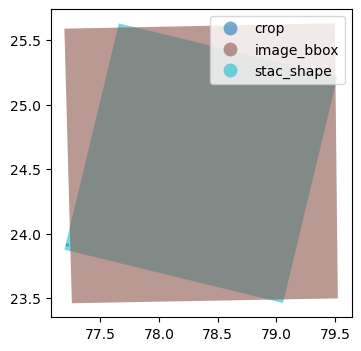

500047
Intersects bbox? False
Intersects STAC geometry? True


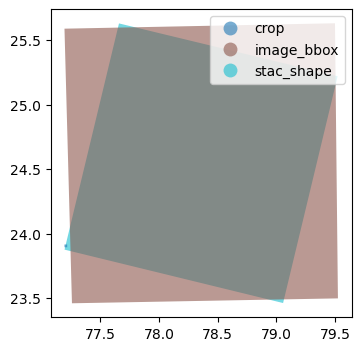

480388
Intersects bbox? False
Intersects STAC geometry? True


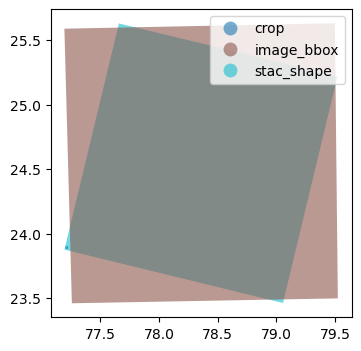

In [43]:
# use loop below or run for selective indices using...
# i = 500045 # 500045 fails, 500015 works
# row = p_44.loc[i]

failing_IDs = []
for i, row in p_44.iterrows():

    stac_item = row["stac_item"]
    lat = row["Lat"]
    lon = row["Lon"]
    buffer = 1200

    stac_crs = stac_item.properties["proj:epsg"]
    x_utm, y_utm = pyproj.Proj(stac_crs)(lon, lat)
    x_min, x_max = x_utm - buffer, x_utm + buffer
    y_min, y_max = y_utm - buffer, y_utm + buffer

    xarray = stackstac.stack(
        stac_item,
        assets=satellite_config["bands"],
        resolution=satellite_config["resolution"],
        rescale=False,
        dtype=np.uint8,
        bounds=[x_min, y_min, x_max, y_max],
        fill_value=0,
        # snap_bounds=False
    )

    # if time dimension is 0 it means the returned xarray is unusable
    time_dim = xarray.shape[0]
    p_44.loc[i, "xarray_time_dim"] = time_dim

    # Check where the point sits inside the image

    # 1. STAC geometry (in same projection as STAC image and crop)
    stac_shape = shapely.geometry.shape(stac_item.geometry)
    stac_shape = gpd.GeoSeries(stac_shape).set_crs("EPSG:4326").to_crs(stac_crs).geometry[0]

    # 2. Use the STAC proj:bbox property to make a shape
    x_min_p, y_min_p, x_max_p, y_max_p = stac_item.properties["proj:bbox"]
    image_bbox = shapely.geometry.Polygon([[x_min_p, y_min_p],[x_min_p, y_max_p], [x_max_p, y_max_p], [x_max_p, y_min_p]])

    # 3. Convert the crop square to a shape
    crop_square = shapely.geometry.Polygon([[x_min, y_min],[x_min, y_max], [x_max, y_max], [x_max, y_min]])

    # Store whether the crop sits within this bounding box/STAC geometry
    p_44.loc[i, "intersects_bbox"] = crop_square.intersects(image_bbox)
    p_44.loc[i, "intersects_geometry"] = crop_square.intersects(stac_shape)

    if time_dim == 0:
        failing_IDs.append(i)

        print(i)
        print("Intersects bbox?", p_44.loc[i, "intersects_bbox"])
        print("Intersects STAC geometry?", p_44.loc[i, "intersects_geometry"])
        
        # plot all shapes
        shapes_gdf = gpd.GeoDataFrame(
            {"item":["stac_shape", "image_bbox", "crop"]}, 
            geometry=[stac_shape, image_bbox, crop_square]
        ).set_crs(stac_crs).to_crs("EPSG:4326")

        shapes_gdf.plot(column="item", legend=True, alpha=0.6, figsize=(4,4))
        plt.show()

In [44]:
# np.array(xarray)

In [49]:
# check how many of the failing points sit inside/outside STAC geometry
crosstab_geom = pd.crosstab(index=p_44["xarray_time_dim"], columns=p_44['intersects_geometry'])
crosstab_geom

intersects_geometry,True
xarray_time_dim,
0.0,7
1.0,892


In [50]:
# check how many of the failing points sit inside/outside bbox
crosstab_bbox = pd.crosstab(index=p_44["xarray_time_dim"], columns=p_44['intersects_bbox'])
crosstab_bbox

intersects_bbox,False,True
xarray_time_dim,,
0.0,7,0
1.0,0,892


So every point that fails sits within the STAC geometry (by definition, since only STAC items that had points inside were fetched based on their given geometry) but outside the "proj:bbox" shape - this must be a data/coding issue on the database end since the bbox should always match the geometry parameter perfectly but sometimes it does not. 

Two solutions:
1. Trim the geometries to within only the area within the bbox (implemented through the `_get_trimmed_stac_shapes_gdf` function in `stacs.py`) when trying to select which STAC item(s) to return for each point. This results in a different STAC item being returned as least cloudy, for example, than the problematic one.
2. Catch xarrays with a 0 time dimension as errors and return None for the points that suffer from this issue. Not preferable as we lose datapoints for no real reason (usually there are other valid images that could be used).

### Design shape trimming function

In [202]:
import shapely
import geopandas as gpd

In [203]:
from mosaiks.featurize.stacs import get_stac_api
stac_api = get_stac_api("planetary-compute")

In [204]:
g = points_gdf_focus.loc[500042]["geometry"]

In [205]:
search_results = stac_api.search(
    collections=["landsat-8-c2-l2"],
    intersects=g,
    datetime=["2013-04-01", "2014-03-31"],
    query={"eo:cloud_cover": {"lt": 10}},
    limit=500,  # this limit seems arbitrary
)

In [206]:
item_collection = search_results.item_collection()
len(item_collection)

18

<AxesSubplot:>

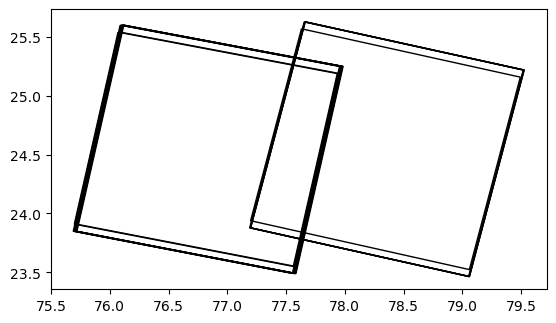

In [291]:
stac_gdf_raw = gpd.GeoDataFrame.from_features(item_collection.to_dict())
stac_gdf_raw.plot(facecolor="none")

In [292]:
import geopandas as gpd
import shapely

def _get_trimmed_stac_shapes_gdf(item_collection):
    """
    To prevent the edge case where a point sits inside the STAC geometry 
    but outwith the STAC proj:bbox shape (resulting in a dud xarray to be 
    returned later), trim the STAC shapes to within the proj:bbox borders.
    
    Parameters
    ----------
    item_collection : pystac.ItemCollection
    
    Returns
    -------
    geopandas.GeoDataFrame
        GeoDataFrame where each row is an Item and columns include 
        cloud cover percentage and item shape trimmed to within proj:bbox.
    """
    
    rows_list = []
    for item in item_collection:
        
        stac_crs = item.properties["proj:epsg"]
        
        # get STAC geometry
        stac_geom = shapely.geometry.shape(item.geometry)
        
        # convert proj:bbox to polygon
        x_min_p, y_min_p, x_max_p, y_max_p = item.properties["proj:bbox"]
        image_bbox = shapely.geometry.Polygon(
            [
                [x_min_p, y_min_p],
                [x_min_p, y_max_p], 
                [x_max_p, y_max_p], 
                [x_max_p, y_min_p],
            ]
        )
        # convert to EPSG:4326 (to match STAC geometry)
        image_bbox = gpd.GeoSeries(image_bbox).set_crs(stac_crs).to_crs(4326).geometry[0]
    
        # trim stac_geom to only what's inside bbox
        trimmed_geom = stac_geom.intersection(image_bbox)
        
        row_data = {
            "eo:cloud_cover":[item.properties["eo:cloud_cover"]],
            "geometry":[trimmed_geom]
        }
        
        row = gpd.GeoDataFrame(row_data, crs=4326)
        rows_list.append(row)
    
    return pd.concat(rows_list)

<AxesSubplot:>

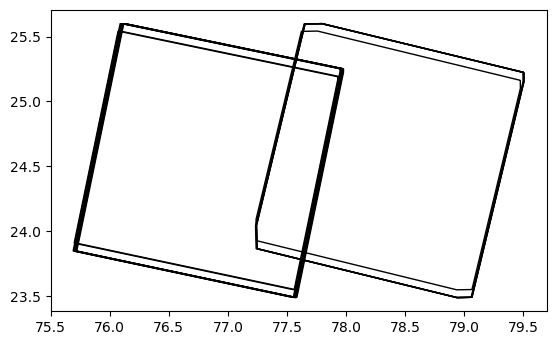

In [293]:
stac_gdf = _get_reprojected_stac_df(item_collection)
stac_gdf.plot(facecolor="none")

In [294]:
stac_gdf_w_point = stac_gdf.merge(gpd.GeoDataFrame({"geometry": g}, index=[18]), how="outer")

<AxesSubplot:>

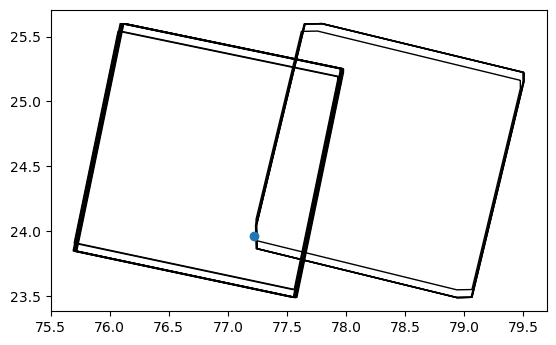

In [298]:
stac_gdf_w_point.plot(facecolor="none")